# 实验原理和装置

功函数，也叫逸出功，是电子溢出金属表面所需要的能量。测量功函数对于电子学有着重要意义。

## 实验原理

本实验通过里查孙直线法测定功函数，即
$$\lg{\frac{I_e}{T^2}} = \lg{(A'S)} - 5040\Phi \frac{1}{T}$$
通过上式，对所测数据进行拟合，通过直线的斜率就能够得出功函数$\Phi$。

由于通常热电子的累积会阻碍新的热电子的发射，故通常情况下，我们需要给热电子一个加速电压。但加速电场会导致测到的发射电流$I_e$的改变。因此为了使用里查孙直线法，需要使用下式来得到不加外场的发射电流：
$$\lg{I_e'} = \lg{I_e} + \frac{0.1912}{T} \frac{1}{\sqrt{r_k \ln{(\frac{r_a}{r_k})}}} \sqrt{V_a - V_c}$$
拟合所测数据，通过截距即可获得不加外场的发射电流。

前两式中有温度，我们通过间接测量的方式获得温度，即通过读出加热电流，根据下式获得温度：
$$T = 1343.79 + 1168.884I_f + 291.6705\ln{I_f}$$

综上，在加外场的情况下，为了获得功函数，只需测量不同温度下的多组加速电压和发射电流即可。

## 实验装置

实验电路图如图：
![design](design.png "design")

图中的四位半表用于测量加速电压，五位半表用来测量发射电流。通过电源可读出加热电流的大小，进而计算出阴极温度。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize

data = pd.read_csv('data.csv')

# 实验步骤及数据处理

## 实验步骤

实验中，我们通过调整电源输出不同加热电流来使阴极达到不同的温度。在某一温度下通过调整电源另一个通道的电压来控制加速电压，在不同的加速电压下测定出相应的发射电流，根据实验原理中的方案即可得到不同温度下对应的功函数。在实验进行过程中，发射电流会不稳定，尤其是在改变温度的时候发射电流随时间有较为明显的变化，我采用的方案是每次调整后等待一段时间，记录稳定时的示数。另外，为了拟合的效果，在特定温度下调节不同加速电压时，我采用的调节值开根号后均匀分布。这样可以避免拟合时疏密不均造成的误差。

实验中测定的各个数据均为电压，对于加速电压，电路图已经保证所测值大约为实际加速电压。而对于发射电流，通过合理的电路设计，我们可以确保流过$1k \Omega$的采样电阻的电流几乎全都是发射电流，故只需电压除以电阻即可，而温度是通过电流大小转换的。

## 数据处理

### 进行两次拟合

首先对不同电压下的发射电流进行拟合，以得到无加速电场时的发射电流。拟合的结果及截距标准差信息如图：

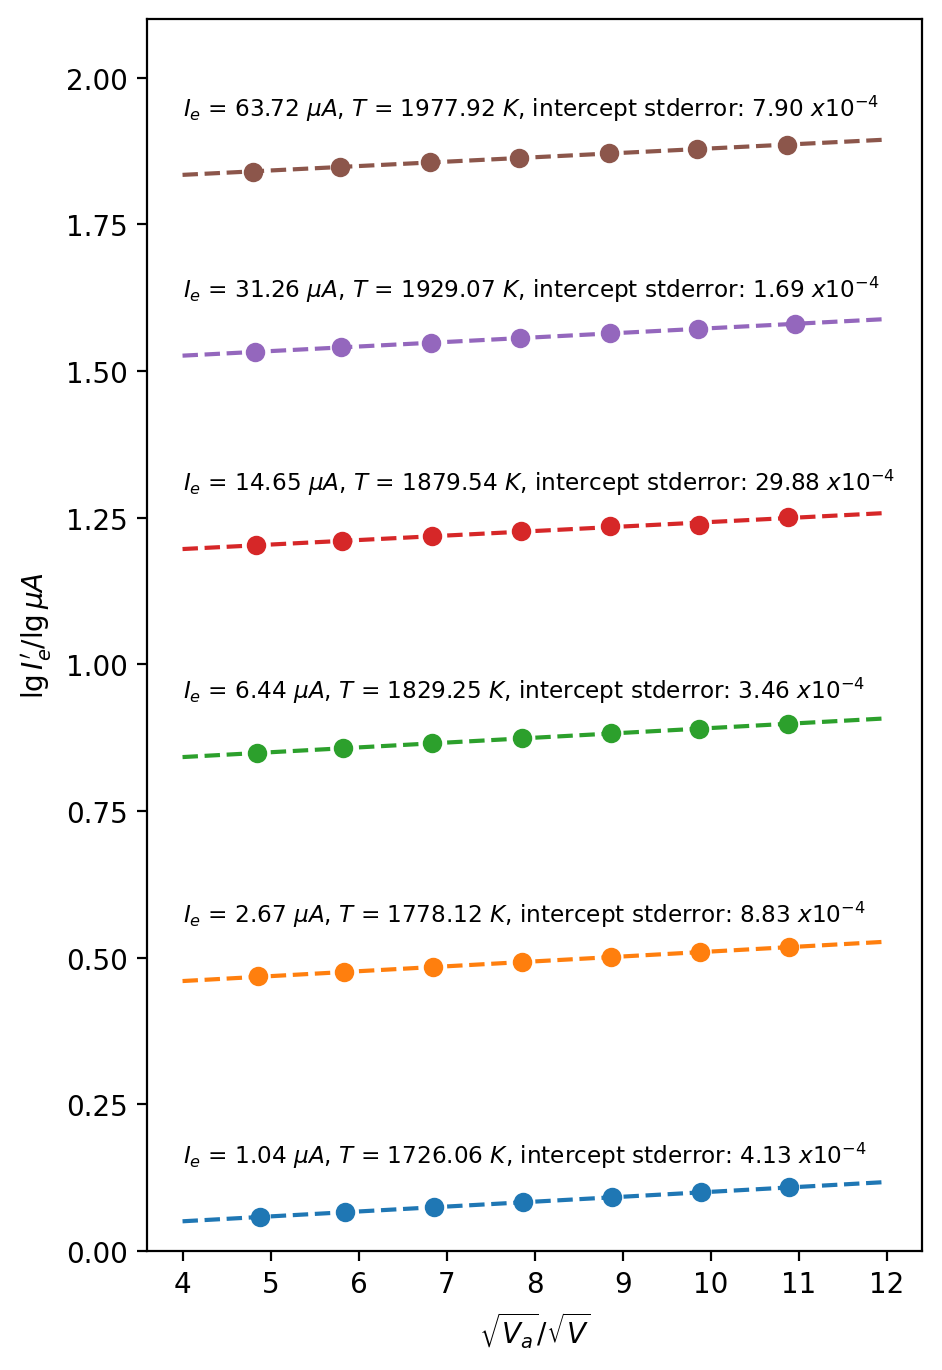

In [2]:
fig1, ax = plt.subplots(figsize=(5,8))

currentNoField = []
temperature = []

for i in range(0,6):
    subdata = data.iloc[7*i:7*i+7]
    accVolt = subdata['四位半表(加速电压)/V']
    exciteCur = subdata['五位半表(发射电流)/mV'] # mV除以1k欧，单位变为微安
    warmingCur = subdata['灯丝电流/A']
    temperature.append(1343.79 + 1168.884 * warmingCur.iloc[0] + 291.6705 * np.log(warmingCur.iloc[0]))
    fitX = np.sqrt(accVolt)
    fitY = np.log10(exciteCur)
    ax.scatter(fitX, fitY)
    res = stats.linregress(fitX, fitY)
    xAxis = np.linspace(4,12)
    yAxis = res.slope * xAxis + res.intercept
    ax.plot(xAxis, yAxis, '--')
    currentNoField.append(np.power(10,res.intercept))
    ax.set_xlabel('$\sqrt{V_a}$/$\sqrt{V}$')
    ax.set_ylim(0,2.1)
    ax.set_ylabel('$\lg{I_e\'}$/$\lg{\mu A}$')
    ax.text(4, 4*res.slope+res.intercept + 0.1, '$I_e$ = %.2f $\mu A$, $T$ = %.2f $K$, intercept stderror: %.2f $x 10^{-4}$' %(currentNoField[i], temperature[i], res.intercept_stderr*10000), fontsize='small')
plt.show()

这样就得到了6组无电场时的发射电流$I_e$与温度$T$的关系，根据实验原理，我们便可以拟合得到阴极（钨）的功函数，拟合结果如下图：

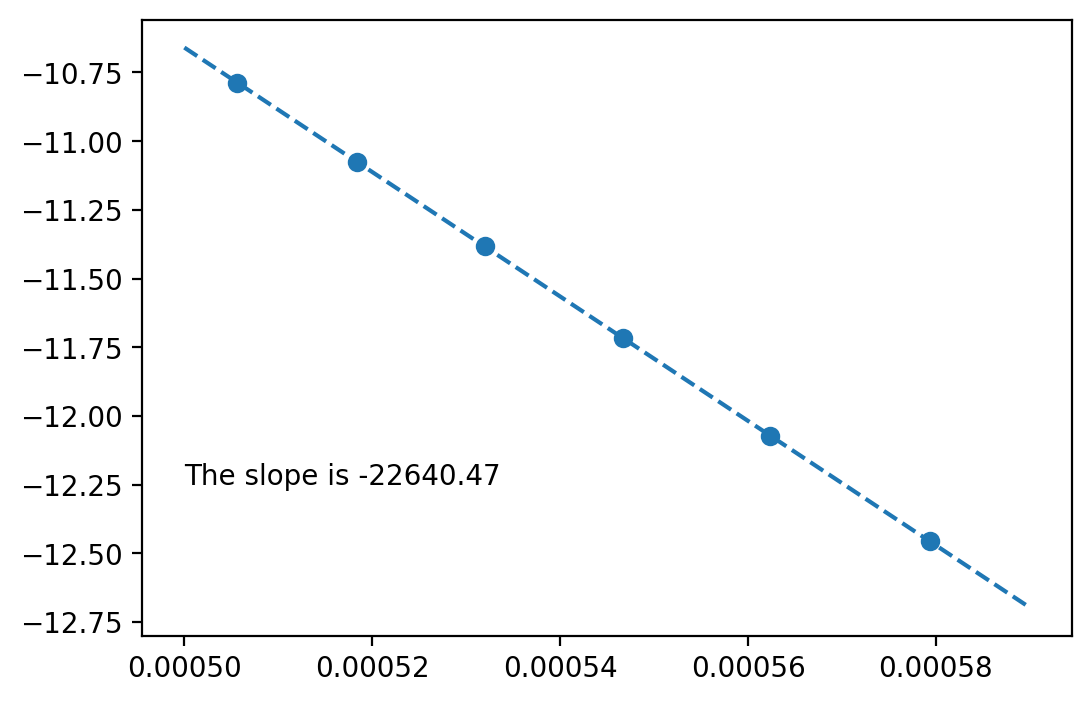

In [3]:
fig2, ax = plt.subplots(figsize=(6,4))
fitX = np.divide(1,temperature)
fitY = np.log10(np.multiply(currentNoField, 0.000001) / np.square(temperature))
ax.scatter(fitX, fitY)
p = np.polyfit(fitX, fitY, 1)
xAxis = np.linspace(0.00050,0.00059)
yAxis = xAxis * p[0] + p[1]
ax.plot(xAxis, yAxis, '--')
ax.text(0.00050, -12.25, 'The slope is %.2f' %p[0])
plt.show()

斜率为$k = -22640.47$，则功函数$\Phi = \frac{k}{-5050} = 4.483eV$，参考数据为钨的功函数约$4.32eV$~$4.55eV$（参见CRC Hand Books of Chem and Phy)，本次实验的测量数据符合前人的测量结果。同时，由第一次拟合的结果可知，一部分误差来自于$1879.5K$时的实验数据。（实际上看拟合直线可发现该组数据有一个明显偏小）

### 多元回归拟合

除了拟合两次，也可以构造一个多元回归方程来计算功函数。根据第一部分的公式，可推导有：
$$[(\lg{I_e'})_{jk}-2(\lg{T})_k] = [\lg{A'S}] + \Phi \cdot [-5040(T^{-1})_k] + [\frac{0.1912}{\sqrt{r_k\ln{(r_a/r_k)}}}] \cdot [(\sqrt{V_a})_j(T^{-1})_k]$$
根据该公式对原始数据进行回归，结果如下：

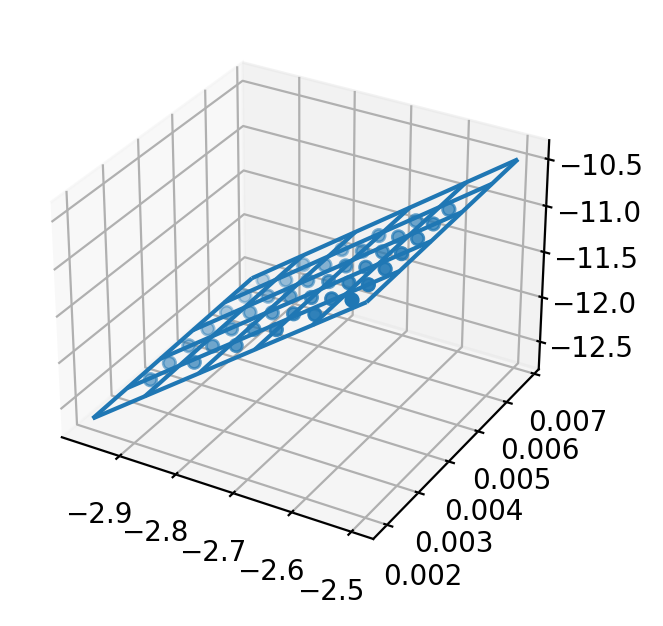

In [4]:
accVolt = data['四位半表(加速电压)/V']
exciteCur = data['五位半表(发射电流)/mV'] # mV除以1k欧，单位变为微安
warmingCur = data['灯丝电流/A']
temperature = 1343.79 + 1168.884 * warmingCur + 291.6705 * np.log(warmingCur)
fitY = np.log10(np.multiply(exciteCur, 1E-6)) - 2 * np.log10(temperature)
fitX1 = -5040 * np.divide(1,temperature)
fitX2 = np.sqrt(accVolt) * np.divide(1,temperature)
def fitFunc(X, a, b, c):
    x1, x2 = X
    return a + x1 * b + x2 * c
[a, b, c], pcov = optimize.curve_fit(fitFunc, [fitX1, fitX2], fitY)
fig3, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(fitX1, fitX2, fitY)
x1 = np.linspace(np.min(fitX1)-0.05,np.max(fitX1)+0.05)
x2 = np.linspace(np.min(fitX2)-0.0005,np.max(fitX2)+0.0005)
xx1, xx2 = np.meshgrid(x1, x2)
y = a + b * xx1 + c * xx2
ax.plot_wireframe(xx1, xx2, y, rstride=10, cstride=10)
plt.show()

使用模型$[(\lg{I_e'})_{jk}-2(\lg{T})_k] = a + b \cdot [-5040(T^{-1})_k] + c \cdot [(\sqrt{V_a})_j(T^{-1})_k]$进行拟合，拟合结果为：$a=0.6695,b=4.495,c=14.81$，这里$b$的值就是功函数$\Phi$，即$\Phi=4.495eV$，同样，该数据在前人的测量范围内。

# 讨论

通过前面的分析，我们发现了一个奇怪的现象：两次拟合得到的功函数和进行二元拟合得到的功函数不同。从技术上来说，两种拟合方式使用的根本数学方法都是最小二乘法。出现不同的结果，可能是因为最小二乘法本质来说是一种寻找最小偏差的计算方法，是对数据做了投影。而对两个数据组分别投影和投影到两个数据组张成的“平面”确实可能得到不同的结果（在两个数据组不完全独立的情况下）。针对这一个实验，我认为进行一个二元函数拟合更为准确，因为实验很难保证两个数据集之间的独立性。

另外，实验在数据测量方面容易出现误差。在实验进行的过程中，我们会发现发射电流明显的不稳定（超过本底很多），尤其是在改变温度之后。这一不稳定有两个原因：一是改变温度之后温度不稳定造成的发射电流不稳定。二是在改变发射电流的过程中即便有加速电压，之前累积的电子也会或多或少的影响发射电流。为了减少不稳定的影响，在实验中所读取数据均为经过约一分钟后的稳定数据，有的不稳定性较高的数据点读取了一段时间内的平均值，同时保证调节电压的方向一致。即便如此，我所读取的数据仍有一定不稳定，不过不影响最终结果。

# 原数据

可在[清华云盘](https://cloud.tsinghua.edu.cn/d/8cefbd2d2132481b8647/)下载源数据（csv格式）和报告源文件（ipynb格式），原数据见下图
![data](data_picture.png "data")